<a href="https://colab.research.google.com/github/kamo1010/injury-big-data/blob/main/SHAP%20Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.5 MB/s eta 0:00:00


In [2]:
pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.9 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [4]:
bank_data = pd.read_csv("sample_data/labels.csv", sep=",", encoding= 'EUC-KR')
bank_data.head(5)

연번    년도  월   일  날  주야간  기상조건  지시  코드1  소속  ...  환자 중상  환자 유형  접수시간/이륙시간  \
0   1  2015  5   4  1    0     0   0    5   6  ...    NaN      3  1444/1452   
1   2  2015  5  13  3    0     0   1    7   2  ...    NaN      6  1238/1250   
2   3  2015  5  14  4    0     0   0    0  75  ...    NaN      3  1205/1216   
3   4  2015  5  15  5    0     0   1    3  21  ...    NaN     12  1658/1707   
4   5  2015  5  18  1    0     0   1    7   2  ...    NaN      7  1156/1202   

  환자 인수지역  도착시간/이륙시간 환자 후송지  후송지 도착 시간  복귀 이륙/복귀도착 NFL  후송결과  
0       1  1500/1505      0       1524   1526/1557   1     0  
1       2  1302/1315      0       1351   1533/1600   0     0  
2       3  1234/1236      0       1259   1303/1327   1     0  
3       4  1712/1713      0       1737   1759/1830   0     0  
4       5  1217/1219      0       1253   1320/1355   0     0  

[5 rows x 21 columns]

In [49]:
def split_time(x):
  x = str(x)
  if x != "nan":
    times = x.split('/')
    times.append(times[1][:2])
    times.append(times[1][2:])
    times[1]=times[0][2:]
    times[0]=times[0][:2]
    return pd.Series(times)
  return ""

bank_data = pd.read_csv("sample_data/labels.csv", sep=",", encoding= 'EUC-KR')
bank_data.head(5)

#step 0
bank_data.rename(columns = {'년도':'year', '월':'month', '일':'day'}, inplace = True)
bank_data.rename(columns = {'날':'day of week', '주야간':'day night', '기상조건':'weather'}, inplace = True)
bank_data.rename(columns = {'지시':'city', '코드1':'region', '소속':'location'}, inplace = True)
bank_data.rename(columns = {'환자 신분':'position', '환자 중상':'wound', '환자 유형':'patient type'}, inplace = True)
bank_data.rename(columns = {'환자 인수지역':'patient acceptance area', '환자 후송지':'patient transfer area'}, inplace = True)
bank_data.rename(columns = {'후송지 도착 시간':'time of arrival at transfer area'}, inplace = True)

# step 1
bank_data = bank_data.drop(columns=["연번"])
bank_data.insert(0, "date", pd.to_datetime(bank_data[["year", "month", "day"]]))

#step 2
#bank_data.insert(1, "season", bank_data['month'].map({1:3, 2:3, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:2, 10:2, 11:2, 12:3}))
#bank_data['day of week'] = bank_data['day of week'].map({'월':0, '화':1, '수':2, '목':3, '금':4, '토':5, '일':6})
#bank_data['day night'] = bank_data['day night'].map({'주':0, '야':1})
#bank_data['weather'] = bank_data['weather'].map({'no-go':0, 'go':1})

#step 6
bank_data[["registration hour", "registration minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['접수시간/이륙시간']), axis=1)
bank_data.insert(11, "registration time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["registration hour"], 'minute': bank_data["registration minute"]})).astype(int))
bank_data.insert(12, "hospital takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['registration hour']).drop(columns=['registration minute']).drop(columns=['접수시간/이륙시간'])

bank_data[["arrival hour", "arrival minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['도착시간/이륙시간']), axis=1)
bank_data.insert(13, "location arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data.insert(14, "patient takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['takeoff hour']).drop(columns=['takeoff minute']).drop(columns=['도착시간/이륙시간'])

bank_data[["departure hour", "departure minute", "arrival hour", "arrival minute"]]= bank_data.apply(lambda x: split_time(x['복귀 이륙/복귀도착']), axis=1)
bank_data.insert(15, "recovery departure time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["departure hour"], 'minute': bank_data["departure minute"]})).astype(int))
bank_data.insert(16, "recovery arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data = bank_data.drop(columns=['departure hour']).drop(columns=['departure minute']).drop(columns=['arrival hour']).drop(columns=['arrival minute']).drop(columns=['복귀 이륙/복귀도착'])

bank_data[["arrival hour", "arrival minute"]]= pd.Series([bank_data['time of arrival at transfer area']//100, bank_data['time of arrival at transfer area']%100])
bank_data["time of arrival at transfer area"] = pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int)
bank_data = bank_data.drop(columns=['arrival hour']).drop(columns=['arrival minute'])
bank_data = bank_data.drop(columns=['year', 'month', 'day', 'date'])

#step 7
bank_data.rename(columns = {'출동~병원':'waiting delay'}, inplace = True)
bank_data["waiting delay"]= (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["registration time"])).astype(int)
bank_data.insert(20, "transfer delay", (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["patient takeoff time"])).astype(int))

#step 8
bank_data.rename(columns = {'후송결과': 'y'}, inplace = True)
#bank_data['y'] = bank_data['y'].map({'사망':0, '생존':1})

#step 9
bank_data = bank_data.drop(columns=['wound'])
levels={'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11, 'l':12, 'm':13, 'n':14, 'o':15, 'p':16, 'q':17, 'r':18, 's':19, 't':20}
#bank_data["position"] = bank_data["position"].map(levels)
columns={"city", "region", "location", "patient type", "patient acceptance area", "patient transfer area"}
for col in columns:
  tmp = {}
  idx = 0
  for elt in bank_data[col]:
    if (elt not in tmp):
      tmp[elt] = idx
      idx+=1
  bank_data[col] = bank_data[col].map(tmp)

bank_data.head(100)

day of week  day night  weather  city  region  location  position  \
0             1          0        0     0       0         0         0   
1             3          0        0     1       1         1         3   
2             4          0        0     0       2         2         1   
3             5          0        0     1       3         3         0   
4             1          0        0     1       1         1         0   
..          ...        ...      ...   ...     ...       ...       ...   
95            5          0        0     0       6        24         3   
96            1          0        0     4       4         8         0   
97            1          0        0     0       7         7         0   
98            3          0        0     0       0        15         0   
99            7          0        0     4       3         3         0   

      registration time  hospital takeoff time  location arrival time  \
0   1430750640000000000    1430751120000000000    1430751600000000000   
1   1431520680000000000    1431521400000000000    1431522120000000000   
2   1431605100000000000    1431605760000000000    1431606840000000000   
3   1431709080000000000    1431709620000000000    1431709920000000000   
4   1431950160000000000    1431950520000000000    1431951420000000000   
..                  ...                    ...                    ...   
95  1463745240000000000    1463745960000000000    1463746560000000000   
96  1464008460000000000    1464009420000000000    1464010500000000000   
97  1464026340000000000    1464026880000000000    1464027480000000000   
98  1464191700000000000    1464192600000000000    1464193320000000000   
99  1464544440000000000    1464545220000000000    1464545880000000000   

    patient takeoff time  recovery departure time  recovery arrival time  \
0    1430751900000000000      1430753160000000000    1430755020000000000   
1    1431522900000000000      1431531180000000000    1431532800000000000   
2    1431606960000000000      1431608580000000000    1431610020000000000   
3    1431709980000000000      1431712740000000000    1431714600000000000   
4    1431951540000000000      1431955200000000000    1431957300000000000   
..                   ...                      ...                    ...   
95   1463746740000000000      1463748240000000000    1463749740000000000   
96   1464010800000000000      1464012600000000000    1464014400000000000   
97   1464027780000000000      1464028920000000000    1464030300000000000   
98   1464193440000000000      1464195240000000000    1464197400000000000   
99   1464546300000000000      1464548640000000000    1464548700000000000   

    patient type  patient acceptance area  patient transfer area  \
0              0                        0                      0   
1              1                        1                      0   
2              0                        2                      0   
3              2                        3                      0   
4              3                        4                      0   
..           ...                      ...                    ...   
95             0                       40                      0   
96             7                       14                      0   
97             7                       40                      0   
98             3                       10                      0   
99             2                       41                      0   

    time of arrival at transfer area  NFL  y  transfer delay  waiting delay  
0                1430753040000000000    1  0   1140000000000  2400000000000  
1                1431525060000000000    0  0   2160000000000  4380000000000  
2                1431608340000000000    1  0   1380000000000  3240000000000  
3                1431711420000000000    0  0   1440000000000  2340000000000  
4                1431953580000000000    0  0   2040000000000  3420000000000  
..                               ...  ... ..        

In [50]:
cat_var = ["day night","weather"]
con_var1 = ['day of week', 'registration time', 'hospital takeoff time', 'location arrival time', 'patient takeoff time', 'recovery departure time', 'recovery arrival time']
con_var2 = ['time of arrival at transfer area', 'waiting delay', 'transfer delay', "position", "city", "region", "location", "patient type", "patient acceptance area", "patient transfer area"]
con_var = con_var1+con_var2

day of week
registration time
hospital takeoff time
location arrival time
patient takeoff time
recovery departure time
recovery arrival time


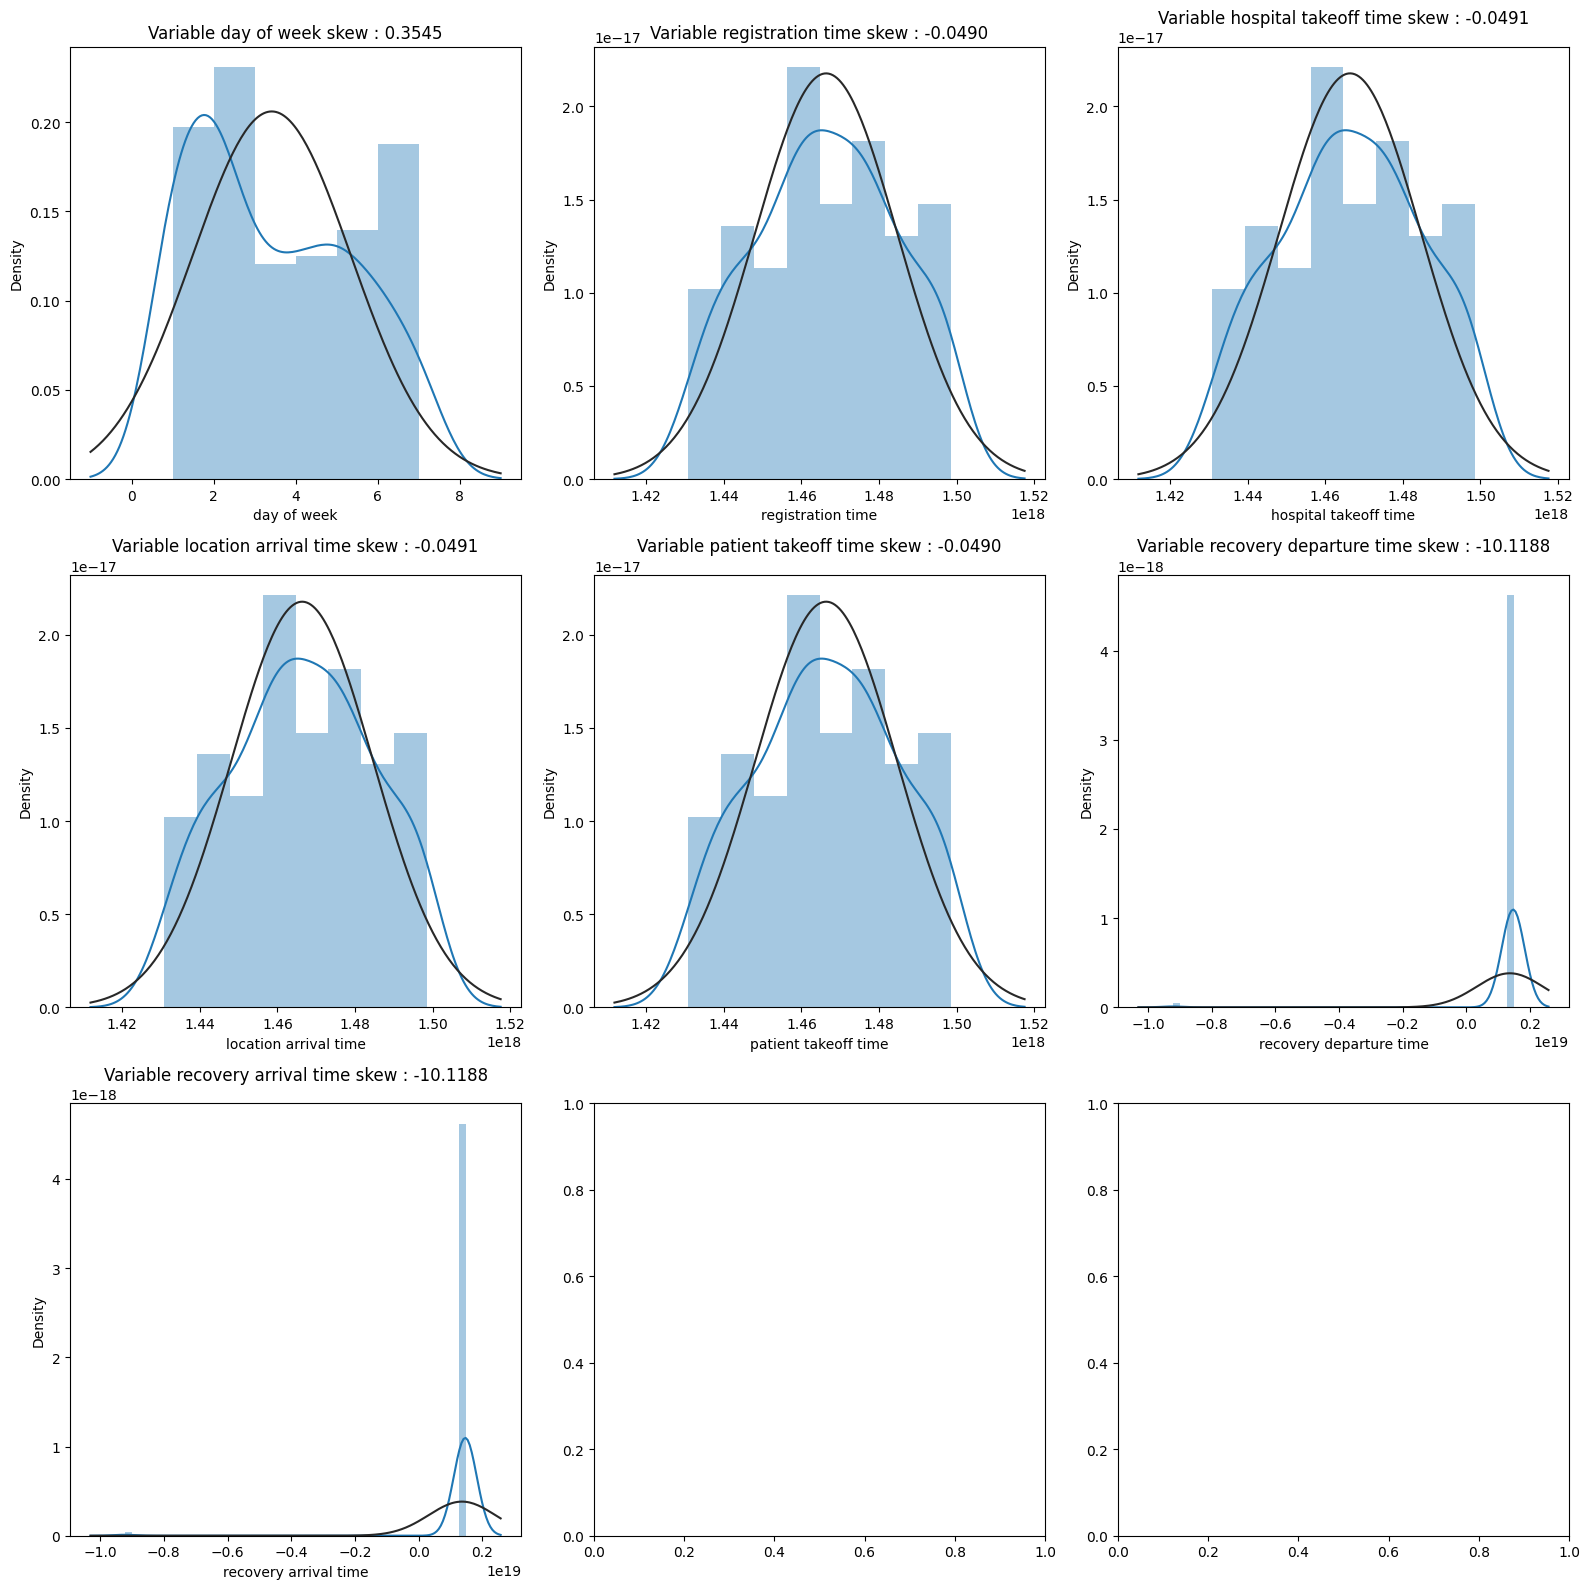

time of arrival at transfer area
waiting delay
transfer delay
position
city
region
location
patient type
patient acceptance area
patient transfer area


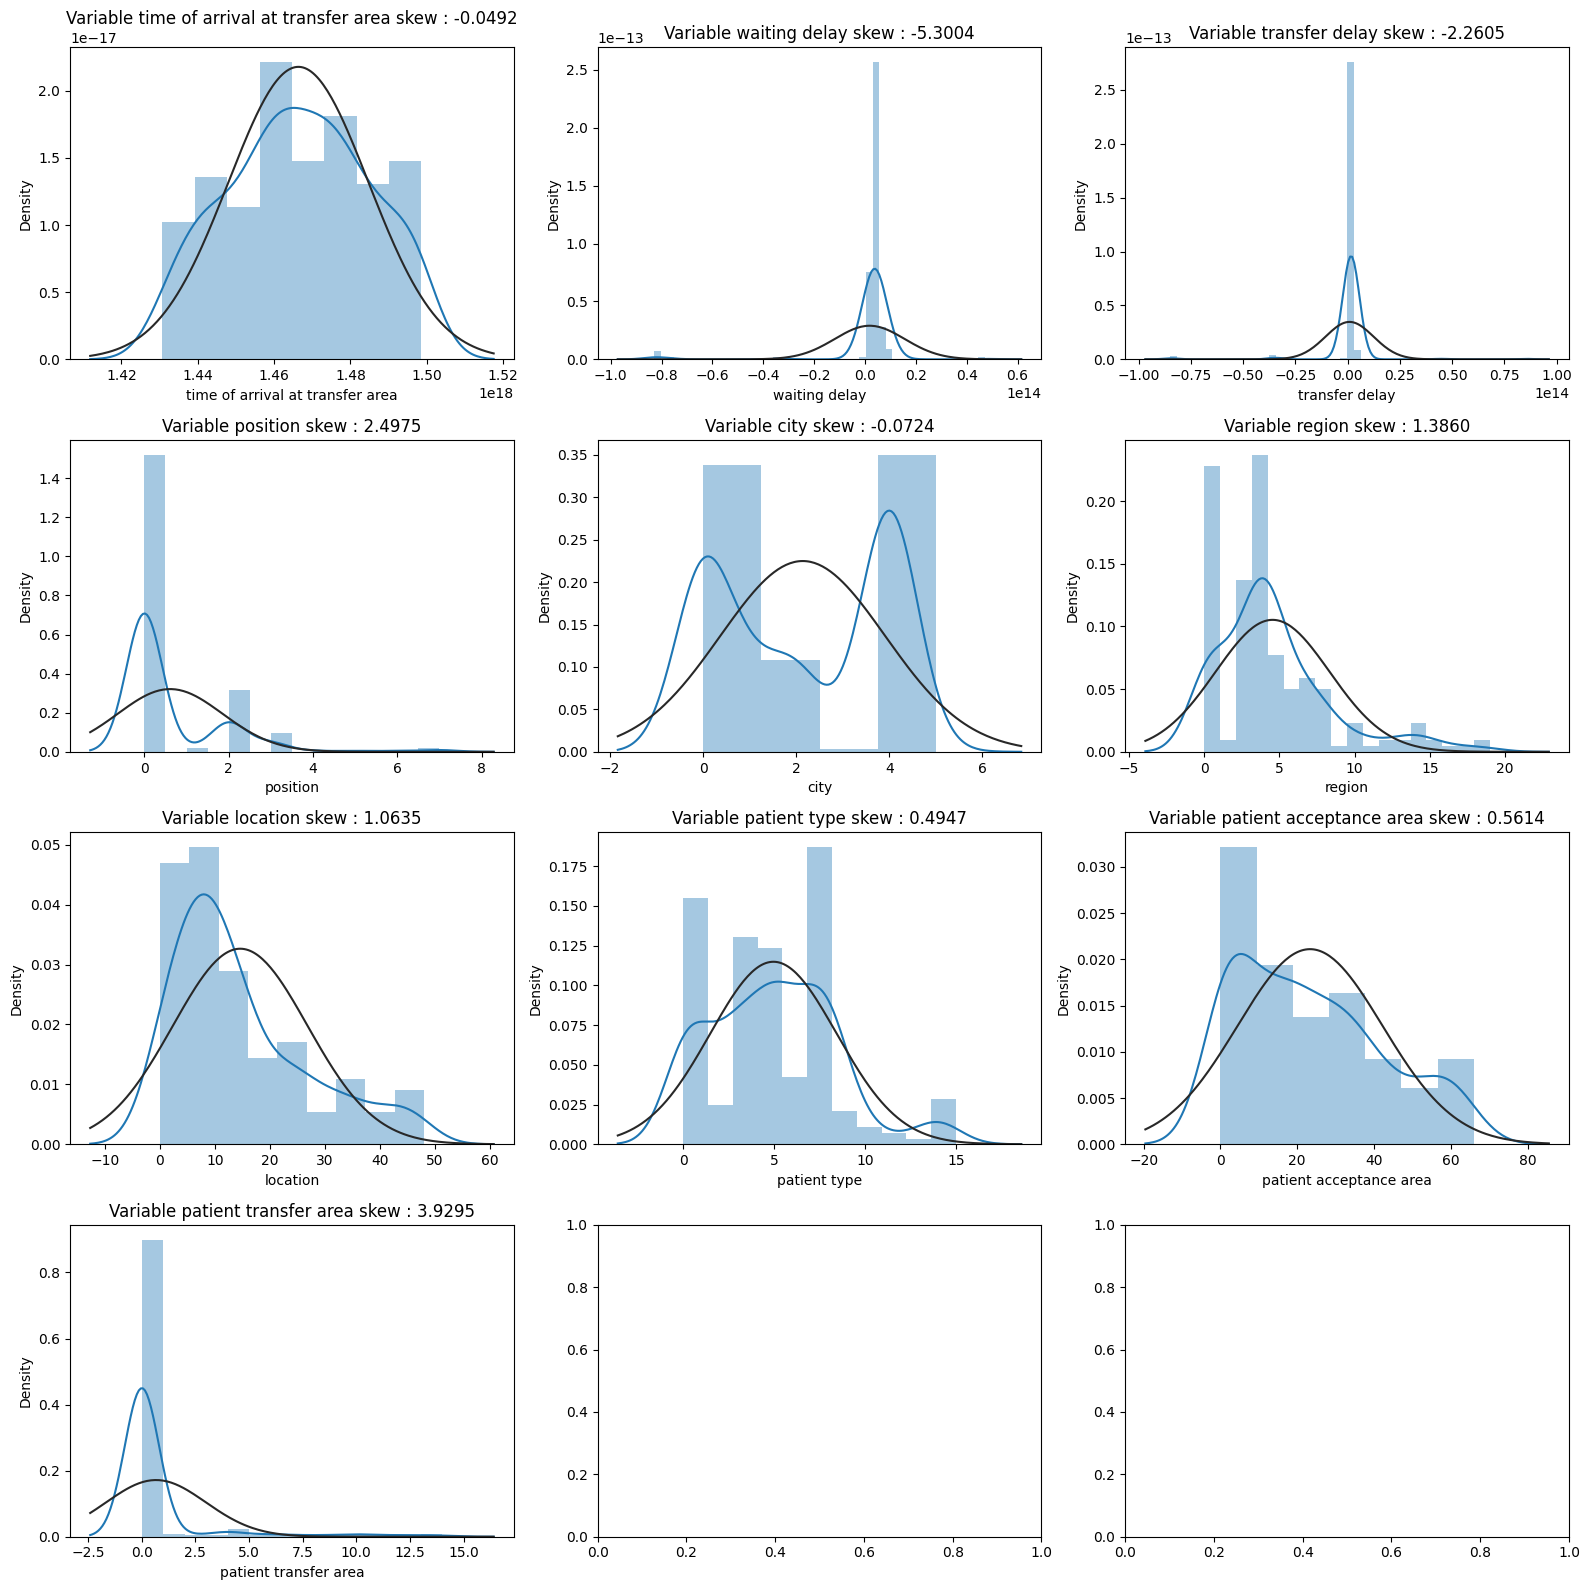

In [51]:
def con_plot(var, idx):
    fig, ax = plt.subplots(int(np.ceil(len(var)/3)), 3, figsize=(16,16))
    ax = ax.flatten()
    i = 0
    for col in var:
        skew = bank_data[col].skew()
        print(col)
        sns.distplot(bank_data[col], fit = stats.norm, ax=ax[i])
        ax[i].set_title("Variable %s skew : %.4f"%(col, skew))
        i+=1
    plt.tight_layout()
    plt.savefig("img/con_plot_"+idx+".png", bbox_inches="tight")
    plt.show()

con_plot(con_var1, "1")
con_plot(con_var2, "2")

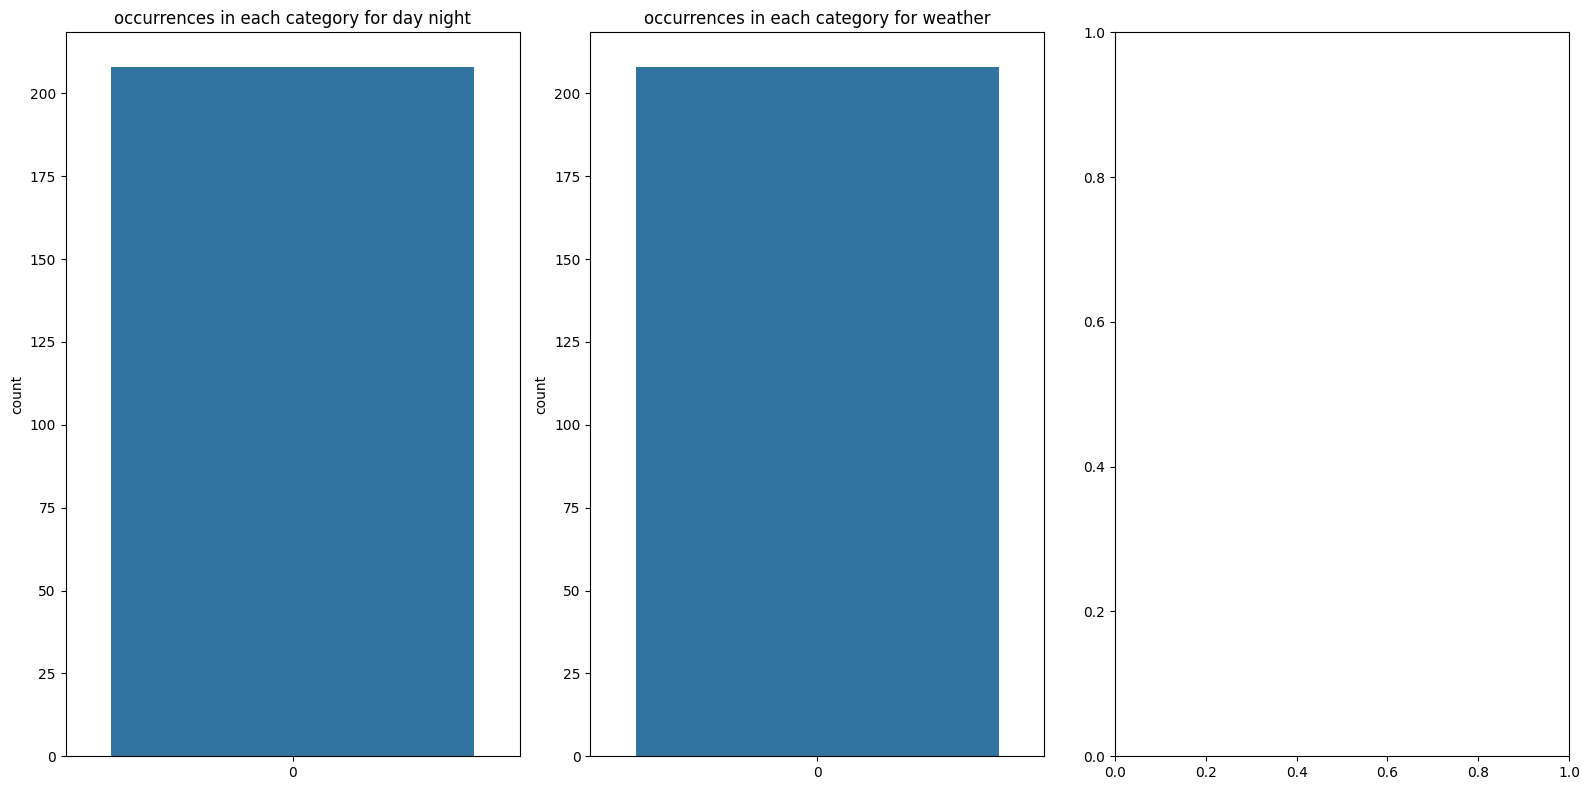

In [53]:
def cat_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(var)/3)), 3, figsize=(16,8))
    ax = ax.flatten()
    i = 0
    for col in var:
        sns.countplot(bank_data[col], ax=ax[i])
        ax[i].set_title("occurrences in each category for %s"%(col))
        i+=1
    plt.tight_layout()
    plt.savefig("img/cat_plot.png", bbox_inches="tight")
    plt.show()

cat_plot(cat_var)

In [16]:
bank_data.isna().sum()

day of week                         0
day night                           0
weather                             0
city                                0
region                              0
location                            0
position                            0
registration time                   0
hospital takeoff time               0
location arrival time               0
patient takeoff time                0
recovery departure time             0
recovery arrival time               0
patient type                        0
patient acceptance area             0
patient transfer area               0
time of arrival at transfer area    0
NFL                                 0
y                                   0
transfer delay                      0
waiting delay                       0
dtype: int64

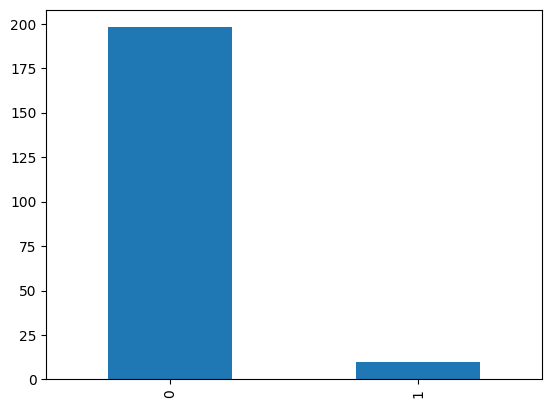

In [17]:
bank_data.y.value_counts().plot(kind='bar')
plt.show()

In [18]:
bank_data.skew()

day of week                          0.354533
day night                            0.914796
weather                              7.052361
city                                -0.072379
region                               1.385955
location                             1.063521
position                             2.497453
registration time                   -0.049047
hospital takeoff time               -0.049116
location arrival time               -0.049082
patient takeoff time                -0.048969
recovery departure time            -10.118751
recovery arrival time              -10.118750
patient type                         0.494735
patient acceptance area              0.561440
patient transfer area                3.929532
time of arrival at transfer area    -0.049151
NFL                                 -0.007111
y                                    4.255738
transfer delay                      -2.260463
waiting delay                       -5.300403
dtype: float64

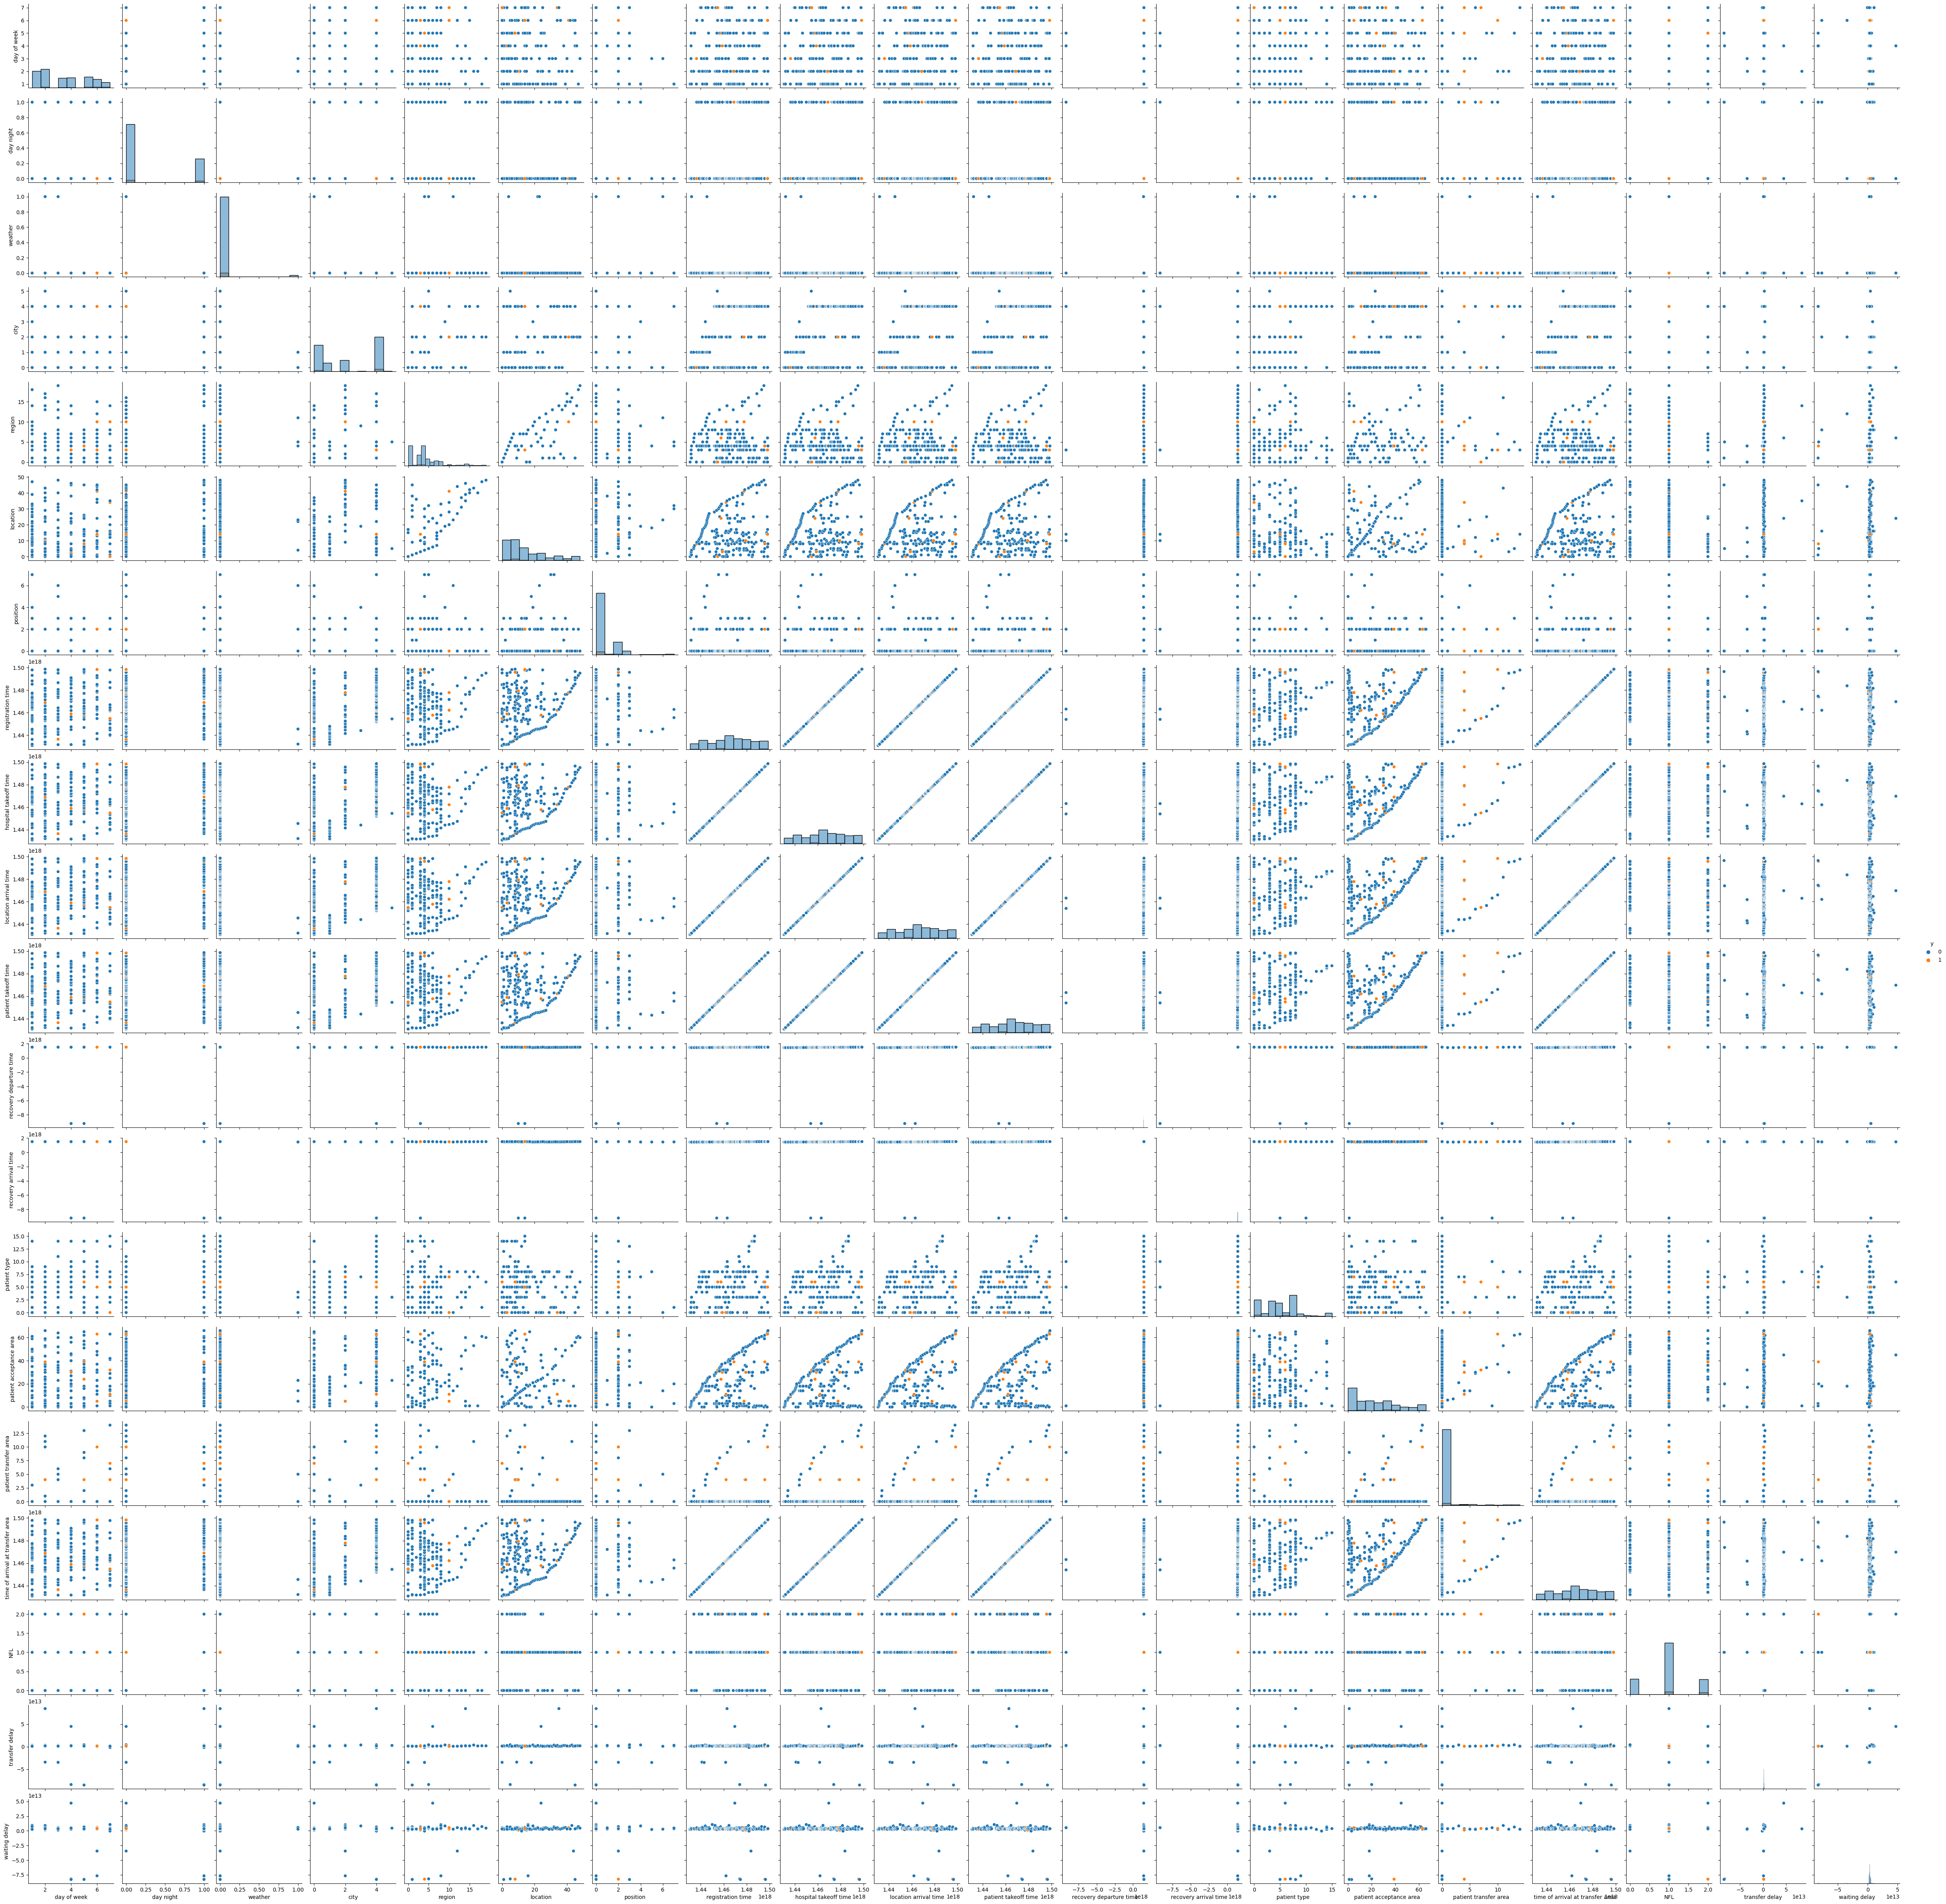

In [19]:
sns.pairplot(bank_data, hue='y', diag_kind='hist')
plt.show()

In [27]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_val = pd.DataFrame({"Col":X.columns})
vif_val["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_val

Col           VIF
0                        day of week  1.033067e+00
1                          day night  1.111504e+00
2                            weather  1.000771e+00
3                               city  1.071097e+00
4                             region  1.040573e+00
5                           location  1.027779e+00
6                           position  1.048473e+00
7                  registration time           inf
8              hospital takeoff time  1.210020e+07
9              location arrival time  1.409817e+07
10              patient takeoff time           inf
11           recovery departure time  1.046371e+10
12             recovery arrival time  1.046371e+10
13                      patient type  1.032725e+00
14           patient acceptance area  1.049865e+00
15             patient transfer area  1.032328e+00
16  time of arrival at transfer area           inf
17                               NFL  1.005199e+00
18                    transfer delay           inf
19                     waiting delay           inf

In [29]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(k_neighbors=3)
over_X, over_y = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)
test = pd.concat([over_X_test, over_y_test], axis=1)

In [30]:
from statistics import mean
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

model_rf = RandomForestClassifier(random_state=1, n_jobs=-1)
model_brf = BalancedRandomForestClassifier(n_estimators=150, random_state=2, n_jobs=-1)
model_logr = LogisticRegression(random_state=1, n_jobs=-1, multi_class='multinomial')
model_lgbm = LGBMClassifier(random_state=1, n_jobs=-1)
model_xgb = XGBClassifier(random_state=1, n_jobs=-1)
model_gbr = GradientBoostingClassifier(random_state=1)
model_cat = CatBoostClassifier(random_state=1, verbose=0)

models = []
models.append(('LR',model_logr))
models.append(('RF',model_rf))
models.append(('BRF', model_brf))
models.append(('GBR',model_gbr))
models.append(('XGB',model_xgb))
models.append(('LGB',model_lgbm))
models.append(('CAT',model_cat))

In [31]:
scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
feature = SelectFromModel(model_rf, threshold=0.001)
ct = ColumnTransformer([('onehot', onehot, cat_var), ('scaler', scaler, con_var)], remainder='passthrough', n_jobs=-1)
results = []
names = []
pipelines = []
for name, model in models:
    pipe = Pipeline([('ct', ct), ('fselect', feature), (name, model)]) # including feature selection step using RF
    #pipe = Pipeline([('ct', ct), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    names.append(name)
    results.append(scores)
    pipelines.append(pipe)
    print("model %s accuracy: %.4f variance: %.4f"%(name, np.mean(scores), np.std(scores)))
for i in range(len(pipelines)):
    pipe = pipelines[i]
    smote_scores = cross_val_score(pipe, over_X_train, over_y_train, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    names.append("SMOTE_"+name)
    results.append(smote_scores)
    print("model %s accuracy with SMOTE: %.4f variance: %.4f"%(names[i], np.mean(smote_scores), np.std(smote_scores)))

model LR accuracy: 0.9379 variance: 0.0258
model RF accuracy: 0.9517 variance: 0.0169
model BRF accuracy: 0.5517 variance: 0.0872
model GBR accuracy: 0.9448 variance: 0.0169
model XGB accuracy: 0.9586 variance: 0.0138
model LGB accuracy: 0.9379 variance: 0.0258
model CAT accuracy: 0.9517 variance: 0.0169
model LR accuracy with SMOTE: 0.7763 variance: 0.0562
model RF accuracy with SMOTE: 0.9567 variance: 0.0088
model BRF accuracy with SMOTE: 0.9639 variance: 0.0161
model GBR accuracy with SMOTE: 0.9422 variance: 0.0212
model XGB accuracy with SMOTE: 0.9531 variance: 0.0216
model LGB accuracy with SMOTE: 0.9711 variance: 0.0089
model CAT accuracy with SMOTE: 0.9674 variance: 0.0178


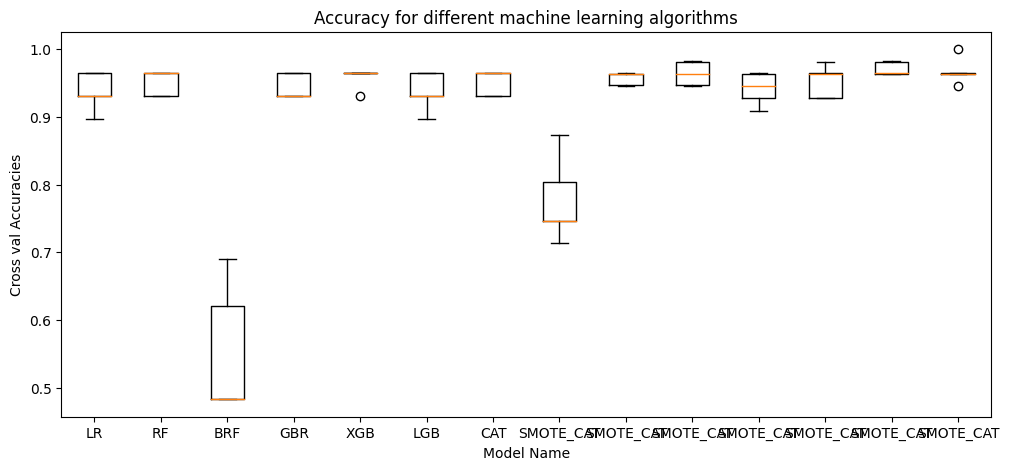

In [32]:
plt.figure(figsize=(12,5))
plt.boxplot(results)
plt.xticks(np.arange(1,len(names)+1),names)
plt.title("Accuracy for different machine learning algorithms")
plt.xlabel("Model Name")
plt.ylabel("Cross val Accuracies")
plt.show()

In [34]:
for i in range(len(models)):
  print(names[i])
  pipelines[i].fit(X_train, y_train)
  trainpred = pipelines[i].predict(X_test)
  print(classification_report(y_test, trainpred))
  print('___________________________________________________________')
  print("SMOTE_"+names[i])
  pipelines[i].fit(over_X_train, over_y_train)
  trainpred = pipelines[i].predict(over_X_test)
  print(classification_report(over_y_test, trainpred))
  print('===========================================================')

LR
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.00      0.00      0.00         3

    accuracy                           0.95        63
   macro avg       0.48      0.50      0.49        63
weighted avg       0.91      0.95      0.93        63

___________________________________________________________
SMOTE_LR
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        60
           1       0.73      0.75      0.74        59

    accuracy                           0.74       119
   macro avg       0.74      0.74      0.74       119
weighted avg       0.74      0.74      0.74       119

RF
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.00      0.00      0.00         3

    accuracy                           0.95        63
   macro avg       0.48      0.50      0.49        63

In [35]:
rf_pipe = RandomForestClassifier(n_estimators=150, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(rf_pipe, over_X, over_y, cv=cv)

# Use random search to find the best hyperparameters
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

n_estimators = randint(50, 500)
max_depth= randint(1, 20)

param_dist = {'n_estimators': n_estimators, 'max_depth': max_depth}
rand_search = RandomizedSearchCV(rf_pipe, param_distributions = param_dist, cv=15)
rand_search.fit(over_X_train, over_y_train)
best_rf = rand_search.best_estimator_

# Print the best parameters
print('Best hyperparameters: ', rand_search.best_params_)

# Generate predictions with the best model
rf_y_pred = best_rf.predict(over_X_test)

sub = pd.DataFrame()

def submission(prediction, model):
    sub["y"] = prediction
    sub.y.value_counts()
    sub.to_csv("model_"+model+"_mobile_price.csv", index=False)
    return sub

sub = submission(rf_y_pred, 'rf')

Best hyperparameters:  {'max_depth': 12, 'n_estimators': 79}


In [36]:
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def saveTrees(rf, path):
  print("Forest population: ", len(best_rf.estimators_))

  # Export all the decision trees from the forest
  index=0
  for tree in best_rf.estimators_:
    dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=5, impurity=False, proportion=True)
    graph = graphviz.Source(dot_data, format="png")
    graph.render(format="png", directory=path+"trees", outfile=path+"trees/"+str(index)+".png")
    index+=1

saveTrees(rf_pipe, "img/SMOTE/")

Forest population:  79


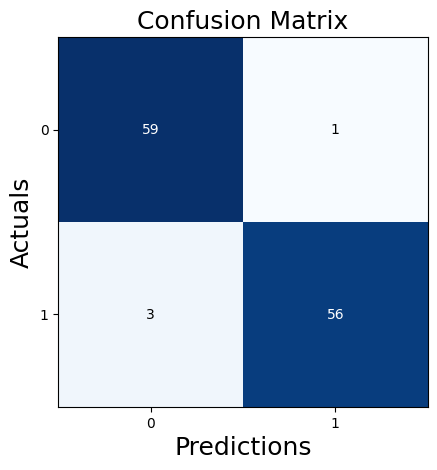

In [37]:
from mlxtend.plotting import plot_confusion_matrix

def saveConfusionMatrix(cm, path):
  fig, ax = plot_confusion_matrix(conf_mat=cm)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.savefig(path+'confusion_matrix.png')

# Create the confusion matrix
rf_cm = confusion_matrix(over_y_test, rf_y_pred)
saveConfusionMatrix(rf_cm, "img/SMOTE/")

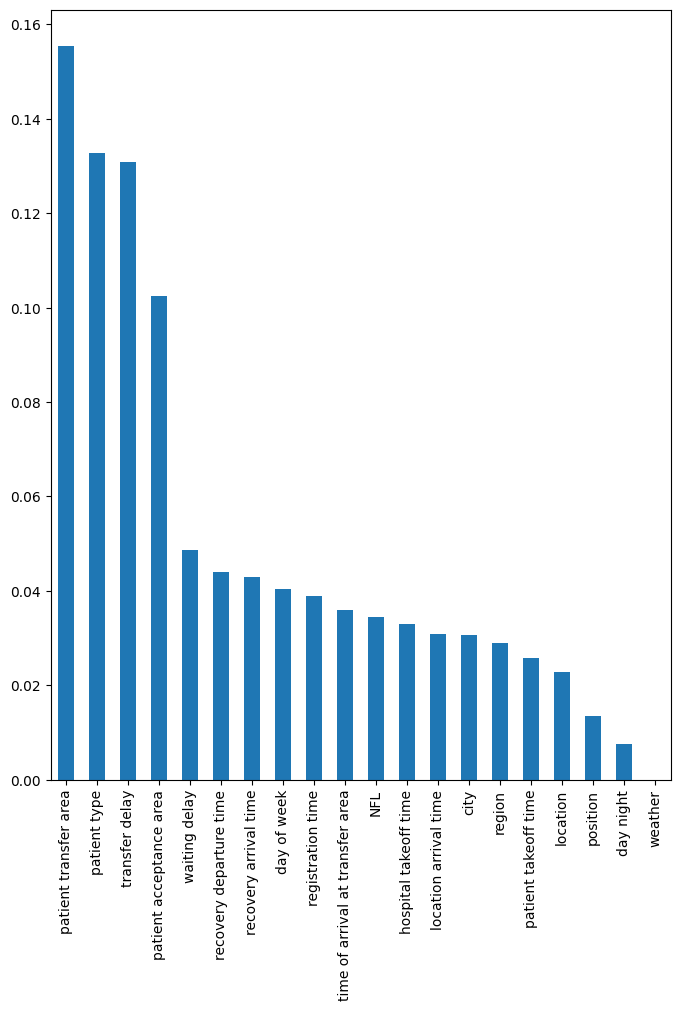

In [38]:
# Create a series containing feature importances from the model and their names from the training data
rf_feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
rf_feature_importances.plot.bar(figsize=(8,10))
plt.savefig("img/SMOTE/criteria.png", bbox_inches="tight")

In [39]:
pip install --upgrade shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.0 MB/s eta 0:00:00


In [40]:
pip install --upgrade eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=395a38d360d5085ec756cca9a7847ebd5ec37487f8246187b40dabfe65a44b88
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


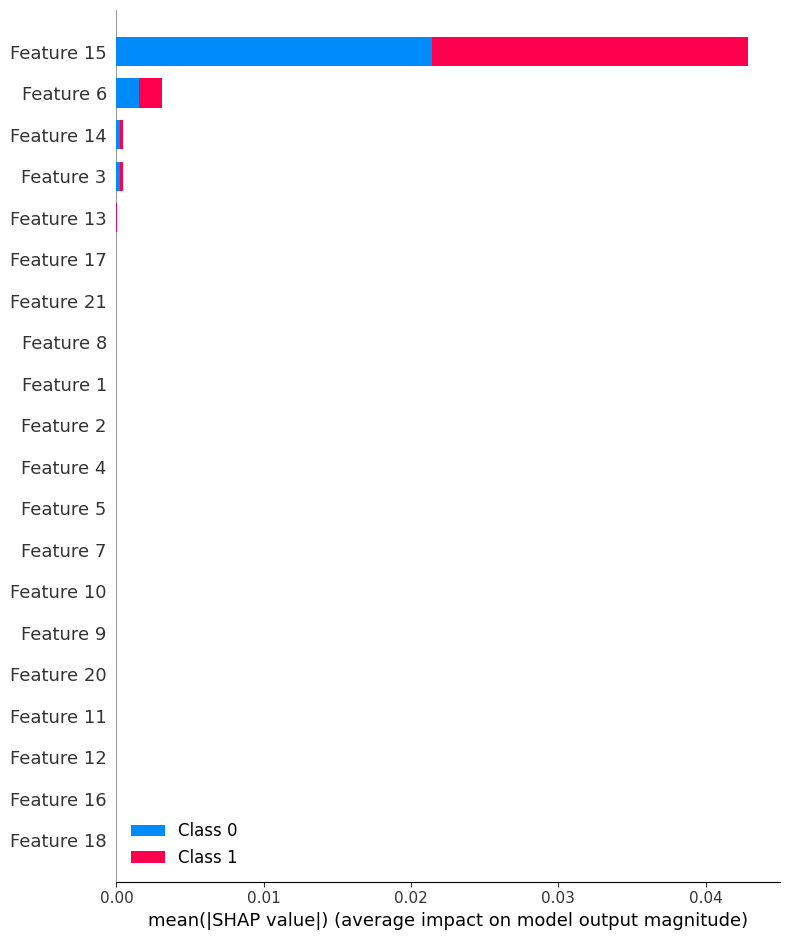

In [41]:
import shap
pd.set_option("display.max_columns",None)
shap.initjs()
import xgboost
import eli5

ct.fit(over_X)
X_shap = ct.fit_transform(over_X)
test_shap  = ct.transform(test)
explainer = shap.TreeExplainer(best_rf, X_shap, feature_perturbation="interventional")
shap_values = explainer.shap_values(test_shap)
shap.summary_plot(shap_values, test_shap)